In [1]:
from tqdm import tqdm
from models import CompletionNetwork, ContextDiscriminator
from datasets import ImageDataset
from losses import completion_network_loss
from utils import (
    gen_input_mask,
    gen_hole_area,
    crop,
    sample_random_batch,
    poisson_blend,
)
from torch.utils.data import DataLoader
from torch.optim import Adadelta, Adam
from torch.nn import BCELoss, DataParallel
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms as transforms
import torch
import random
import os
import argparse
import numpy as np
import json
import time

import glob

In [2]:
data_path = "/root/notebooks/final/gandata/gandata1"
out_path = "/root/notebooks/final/gandata/result"

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', type=str, default=data_path)
parser.add_argument('--result_dir', type=str, default=out_path)
parser.add_argument('--recursive_search', action='store_true', default=False)
parser.add_argument('--init_model_cn', type=str, default=None)
parser.add_argument('--init_model_cd', type=str, default=None)
parser.add_argument('--steps_1', type=int, default=100)
parser.add_argument('--steps_2', type=int, default=100)
parser.add_argument('--steps_3', type=int, default=100)
parser.add_argument('--snaperiod_1', type=int, default=10000)
parser.add_argument('--snaperiod_2', type=int, default=2000)
parser.add_argument('--snaperiod_3', type=int, default=10000)
parser.add_argument('--max_holes', type=int, default=1)
parser.add_argument('--hole_min_w', type=int, default=48)
parser.add_argument('--hole_max_w', type=int, default=96)
parser.add_argument('--hole_min_h', type=int, default=48)
parser.add_argument('--hole_max_h', type=int, default=96)
parser.add_argument('--cn_input_size', type=int, default=160)
parser.add_argument('--ld_input_size', type=int, default=96)
parser.add_argument('--optimizer', type=str, choices=['adadelta', 'adam'], default='adadelta')
parser.add_argument('--bsize', type=int, default=16)
parser.add_argument('--bdivs', type=int, default=1)
parser.add_argument('--data_parallel', action='store_true')
parser.add_argument('--num_test_completions', type=int, default=16)
parser.add_argument('--mpv', nargs=3, type=float, default=None)
parser.add_argument('--alpha', type=float, default=4e-4)
parser.add_argument('--arc', type=str, choices=['celeba', 'places2'], default='celeba')

parser.add_argument('-f')

_StoreAction(option_strings=['-f'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

In [4]:
args = parser.parse_args()

In [5]:
# ================================================
# Preparation
# ================================================
args.data_dir = os.path.expanduser(args.data_dir)
args.result_dir = os.path.expanduser(args.result_dir)
if args.init_model_cn != None:
    args.init_model_cn = os.path.expanduser(args.init_model_cn)
if args.init_model_cd != None:
    args.init_model_cd = os.path.expanduser(args.init_model_cd)
if torch.cuda.is_available() == False:
    raise Exception('At least one gpu must be available.')
else:
    gpu = torch.device('cuda:0')

# create result directory (if necessary)
if os.path.exists(args.result_dir) == False:
    os.makedirs(args.result_dir)
for s in ['phase_1', 'phase_2', 'phase_3']:
    if os.path.exists(os.path.join(args.result_dir, s)) == False:
        os.makedirs(os.path.join(args.result_dir, s))


In [6]:
# dataset
trnsfm = transforms.Compose([
    #transforms.Resize(args.cn_input_size),
    #transforms.RandomCrop((args.cn_input_size, args.cn_input_size)),
    transforms.ToTensor(),
])


test_dset = ImageDataset(args.data_dir, trnsfm, recursive_search=args.recursive_search)

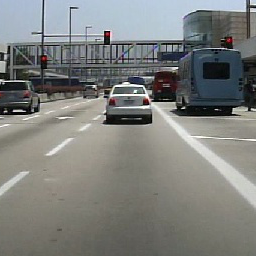

In [15]:
test_dset.__getitem__(1000)[0]

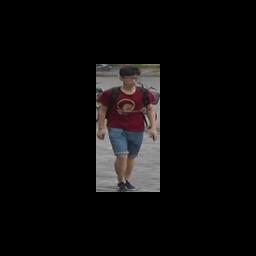

In [16]:
test_dset.__getitem__(1000)[1]

In [19]:
# dataset
trnsfm = transforms.Compose([
    #transforms.Resize(args.cn_input_size),
    #transforms.RandomCrop((args.cn_input_size, args.cn_input_size)),
    transforms.ToTensor(),
])
print('loading dataset... (it may take a few minutes)')
train_dset = ImageDataset(args.data_dir, trnsfm, recursive_search=args.recursive_search)
test_dset = ImageDataset(args.data_dir, trnsfm, recursive_search=args.recursive_search)
train_loader = DataLoader(train_dset, batch_size=(args.bsize // args.bdivs), shuffle=True)

# compute mean pixel value of training dataset
mpv = np.zeros(shape=(3,))
if args.mpv == None:
    pbar = tqdm(total=len(train_dset.street_imgpaths), desc='computing mean pixel value for training dataset...')
    for imgpath in train_dset.street_imgpaths:
        img = Image.open(imgpath)
        x = np.array(img, dtype=np.float32) / 255.
        mpv += x.mean(axis=(0,1))
        pbar.update()
    mpv /= len(train_dset.street_imgpaths)
    pbar.close()
else:
    mpv = np.array(args.mpv)

# save training config
mpv_json = []
for i in range(3):
    mpv_json.append(float(mpv[i])) # convert to json serializable type
args_dict = vars(args)
args_dict['mpv'] = mpv_json
with open(os.path.join(args.result_dir, 'config.json'), mode='w') as f:
    json.dump(args_dict, f)

# make mpv & alpha tensor
mpv = torch.tensor(mpv.astype(np.float32).reshape(1, 3, 1, 1)).to(gpu)
alpha = torch.tensor(args.alpha).to(gpu)


loading dataset... (it may take a few minutes)



computing mean pixel value for training dataset...:   0%|          | 0/5000 [00:00<?, ?it/s]
computing mean pixel value for training dataset...:   0%|          | 11/5000 [00:00<00:46, 106.55it/s]
computing mean pixel value for training dataset...:   1%|          | 26/5000 [00:00<00:43, 115.59it/s]
computing mean pixel value for training dataset...:   1%|          | 38/5000 [00:00<00:42, 116.59it/s]
computing mean pixel value for training dataset...:   1%|          | 51/5000 [00:00<00:41, 119.67it/s]
computing mean pixel value for training dataset...:   1%|▏         | 64/5000 [00:00<00:41, 120.28it/s]
computing mean pixel value for training dataset...:   2%|▏         | 76/5000 [00:00<00:41, 119.84it/s]
computing mean pixel value for training dataset...:   2%|▏         | 89/5000 [00:00<00:40, 121.27it/s]
computing mean pixel value for training dataset...:   2%|▏         | 102/5000 [00:00<00:39, 123.00it/s]
computing mean pixel value for training dataset...:   2%|▏         | 115/5000 [00

In [ ]:
# ================================================
# Training Phase 2
# ================================================
model_cd = ContextDiscriminator(
    local_input_shape=(3, args.ld_input_size, args.ld_input_size),
    global_input_shape=(3, args.cn_input_size, args.cn_input_size),
    arc=args.arc,
)
if args.data_parallel:
    model_cd = DataParallel(model_cd)
if args.init_model_cd != None:
    model_cd.load_state_dict(torch.load(args.init_model_cd, map_location='cpu'))
if args.optimizer == 'adadelta':
    opt_cd = Adadelta(model_cd.parameters())
else:
    opt_cd = Adam(model_cd.parameters())
model_cd = model_cd.to(gpu)
bceloss = BCELoss()

# training
cnt_bdivs = 0
pbar = tqdm(total=args.steps_2)
while pbar.n < args.steps_2:
    for x in train_loader:

        # fake forward
        x = x.to(gpu)
        hole_area_fake = gen_hole_area((args.ld_input_size, args.ld_input_size), (x.shape[3], x.shape[2]))
        mask = gen_input_mask(
            shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
            hole_size=((args.hole_min_w, args.hole_max_w), (args.hole_min_h, args.hole_max_h)),
            hole_area=hole_area_fake,
            max_holes=args.max_holes,
        ).to(gpu)
        fake = torch.zeros((len(x), 1)).to(gpu)
        x_mask = x - x * mask + mpv * mask
        input_cn = torch.cat((x_mask, mask), dim=1)
        output_cn = model_cn(input_cn)
        input_gd_fake = output_cn.detach()
        input_ld_fake = crop(input_gd_fake, hole_area_fake)
        output_fake = model_cd((input_ld_fake.to(gpu), input_gd_fake.to(gpu)))
        loss_fake = bceloss(output_fake, fake)

        # real forward
        hole_area_real = gen_hole_area(size=(args.ld_input_size, args.ld_input_size), mask_size=(x.shape[3], x.shape[2]))
        real = torch.ones((len(x), 1)).to(gpu)
        input_gd_real = x
        input_ld_real = crop(input_gd_real, hole_area_real)
        output_real = model_cd((input_ld_real, input_gd_real))
        loss_real = bceloss(output_real, real)

        # reduce
        loss = (loss_fake + loss_real) / 2.

        # backward
        loss.backward()
        cnt_bdivs += 1

        if cnt_bdivs >= args.bdivs:
            cnt_bdivs = 0
            # optimize
            opt_cd.step()
            # clear grads
            opt_cd.zero_grad()
            # update progbar
            pbar.set_description('phase 2 | train loss: %.5f' % loss.cpu())
            pbar.update()
            # test
            if pbar.n % args.snaperiod_2 == 0:
                with torch.no_grad():
                    x = sample_random_batch(test_dset, batch_size=args.num_test_completions).to(gpu)
                    mask = gen_input_mask(
                        shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
                        hole_size=((args.hole_min_w, args.hole_max_w), (args.hole_min_h, args.hole_max_h)),
                        hole_area=gen_hole_area((args.ld_input_size, args.ld_input_size), (x.shape[3], x.shape[2])),
                        max_holes=args.max_holes,
                    ).to(gpu)
                    x_mask = x - x * mask + mpv * mask
                    input = torch.cat((x_mask, mask), dim=1)
                    output = model_cn(input)
                    completed = poisson_blend(x, output, mask)
                    imgs = torch.cat((x.cpu(), x_mask.cpu(), completed.cpu()), dim=0)
                    imgpath = os.path.join(args.result_dir, 'phase_2', 'step%d.png' % pbar.n)
                    model_cd_path = os.path.join(args.result_dir, 'phase_2', 'model_cd_step%d' % pbar.n)
                    save_image(imgs, imgpath, nrow=len(x))
                    if args.data_parallel:
                        torch.save(model_cd.module.state_dict(), model_cd_path)
                    else:
                        torch.save(model_cd.state_dict(), model_cd_path)
            # terminate
            if pbar.n >= args.steps_2:
                break
pbar.close()

In [ ]:
# ================================================
# Training Phase 3
# ================================================
# training
cnt_bdivs = 0
pbar = tqdm(total=args.steps_3)
while pbar.n < args.steps_3:
    for x in train_loader:

        # forward model_cd
        x = x.to(gpu)
        hole_area_fake = gen_hole_area((args.ld_input_size, args.ld_input_size), (x.shape[3], x.shape[2]))
        mask = gen_input_mask(
            shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
            hole_size=((args.hole_min_w, args.hole_max_w), (args.hole_min_h, args.hole_max_h)),
            hole_area=hole_area_fake,
            max_holes=args.max_holes,
        ).to(gpu)

        # fake forward
        fake = torch.zeros((len(x), 1)).to(gpu)
        x_mask = x - x * mask + mpv * mask
        input_cn = torch.cat((x_mask, mask), dim=1)
        output_cn = model_cn(input_cn)
        input_gd_fake = output_cn.detach()
        input_ld_fake = crop(input_gd_fake, hole_area_fake)
        output_fake = model_cd((input_ld_fake, input_gd_fake))
        loss_cd_fake = bceloss(output_fake, fake)

        # real forward
        hole_area_real = gen_hole_area(size=(args.ld_input_size, args.ld_input_size), mask_size=(x.shape[3], x.shape[2]))
        real = torch.ones((len(x), 1)).to(gpu)
        input_gd_real = x
        input_ld_real = crop(input_gd_real, hole_area_real)
        output_real = model_cd((input_ld_real, input_gd_real))
        loss_cd_real = bceloss(output_real, real)

        # reduce
        loss_cd = (loss_cd_fake + loss_cd_real) * alpha / 2.

        # backward model_cd
        loss_cd.backward()

        cnt_bdivs += 1
        if cnt_bdivs >= args.bdivs:
            # optimize
            opt_cd.step()
            # clear grads
            opt_cd.zero_grad()

        # forward model_cn
        loss_cn_1 = completion_network_loss(x, output_cn, mask)
        input_gd_fake = output_cn
        input_ld_fake = crop(input_gd_fake, hole_area_fake)
        output_fake = model_cd((input_ld_fake, (input_gd_fake)))
        loss_cn_2 = bceloss(output_fake, real)

        # reduce
        loss_cn = (loss_cn_1 + alpha * loss_cn_2) / 2.

        # backward model_cn
        loss_cn.backward()

        if cnt_bdivs >= args.bdivs:
            cnt_bdivs = 0
            # optimize
            opt_cn.step()
            # clear grads
            opt_cn.zero_grad()
            # update progbar
            pbar.set_description('phase 3 | train loss (cd): %.5f (cn): %.5f' % (loss_cd.cpu(), loss_cn.cpu()))
            pbar.update()
            # test
            if pbar.n % args.snaperiod_3 == 0:
                with torch.no_grad():
                    x = sample_random_batch(test_dset, batch_size=args.num_test_completions).to(gpu)
                    mask = gen_input_mask(
                        shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
                        hole_size=((args.hole_min_w, args.hole_max_w), (args.hole_min_h, args.hole_max_h)),
                        hole_area=gen_hole_area((args.ld_input_size, args.ld_input_size), (x.shape[3], x.shape[2])),
                        max_holes=args.max_holes,
                    ).to(gpu)
                    x_mask = x - x * mask + mpv * mask
                    input = torch.cat((x_mask, mask), dim=1)
                    output = model_cn(input)
                    completed = poisson_blend(x, output, mask)
                    imgs = torch.cat((x.cpu(), x_mask.cpu(), completed.cpu()), dim=0)
                    imgpath = os.path.join(args.result_dir, 'phase_3', 'step%d.png' % pbar.n)
                    model_cn_path = os.path.join(args.result_dir, 'phase_3', 'model_cn_step%d' % pbar.n)
                    model_cd_path = os.path.join(args.result_dir, 'phase_3', 'model_cd_step%d' % pbar.n)
                    save_image(imgs, imgpath, nrow=len(x))
                    if args.data_parallel:
                        torch.save(model_cn.module.state_dict(), model_cn_path)
                        torch.save(model_cd.module.state_dict(), model_cd_path)
                    else:
                        torch.save(model_cn.state_dict(), model_cn_path)
                        torch.save(model_cd.state_dict(), model_cd_path)
            # terminate
            if pbar.n >= args.steps_3:
                break
pbar.close()